### Testing the LESS denoising code on mock data

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display
import torch
import sys
import os
less_path = os.path.abspath(os.path.join("..", "LESS_ver_alpha"))
if less_path not in sys.path:
    sys.path.insert(0, less_path)
from less import denoise
from utils import set_seed
from scipy.ndimage import gaussian_filter1d
import seaborn as sns
from scipy.stats import skewnorm

In [3]:
def run_less_denoising(movie_np: np.ndarray,
                           patch_size: int = 16,
                           top_k: int = 18,
                           window_size: int = 37,
                           stride: int = 4,
                           pat: int = 5,
                           seed: int = 42,
                           verbose: bool = False) -> np.ndarray:
    """
    Run LESS denoising on a NumPy movie array.

    Parameters:
        movie_np (np.ndarray): Input movie of shape (T, H, W)
        patch_size (int): Patch size
        top_k (int): Number of best-matching patches
        window_size (int): Search window size
        stride (int): Stride for patch selection
        pat (int): Temporal patch size (number of adjacent frames)
        seed (int): Random seed
        verbose (bool): Whether to print progress

    Returns:
        np.ndarray: Denoised movie of shape (T, H, W)
    """
    assert movie_np.ndim == 3, "Input movie must have shape (T, H, W)"
    set_seed(seed)

    movie_tensor = torch.from_numpy(movie_np).float()

    denoised_tensor = denoise(
        data=movie_tensor,
        cuda=False,               # Force CPU
        patch_size=patch_size,
        top_k=top_k,
        window_size=window_size,
        stride=stride,
        pat=pat,
        verbose=verbose
    )

    return denoised_tensor.numpy()

In [4]:
def show_movies(original, noisy, denoised, fps=30, titles=("Original", "Noisy", "Denoised")):
    plt.close('all')  # Close any previously open figures

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    ims = [ax.imshow(frames[0], cmap='gray', vmin=original.min(), vmax=original.max(), aspect='auto') 
           for frames, ax in zip([original, noisy, denoised], axes)]

    for ax, title in zip(axes, titles):
        ax.set_title(title)
        ax.axis("off")
    
    def update(i):
        for im, frames in zip(ims, [original, noisy, denoised]):
            im.set_array(frames[i])
        return ims

    ani = animation.FuncAnimation(fig, update, frames=len(original), interval=1000/fps, blit=True)

    return ani

In [5]:
def denoise_and_plot(movie_clean, noise, fps, **kwargs):
    """
    Combine signal and noise, run denoising, plot side-by-side.
    
    Parameters:
        movie_clean (ndarray): Clean synthetic movie (T, H, W)
        noise (ndarray): Noise to add (same shape as movie_clean)
        fps (int): Frames per second
        **kwargs: Additional arguments to pass to run_less_denoising
                  (e.g., patch_size=16, seed=123)
    """
    movie_noisy = movie_clean + noise
    movie_denoised = run_less_denoising(movie_noisy, verbose=False, **kwargs)
    ani = show_movies(movie_clean, movie_noisy, movie_denoised, fps=fps)
    return ani

In [6]:
def compute_nmse(signal: np.ndarray, noise: np.ndarray) -> float:
    """
    Generate a noisy movie by adding noise to a clean signal, denoise it,
    and compute the normalized mean squared error (NMSE) between the original
    signal and the denoised movie.

    Parameters:
        signal (np.ndarray): Clean movie of shape (T, H, W)
        noise (np.ndarray): Noise movie of same shape as signal

    Returns:
        float: Normalized mean squared error (NMSE)
    """
    assert signal.shape == noise.shape, "Signal and noise must have the same shape."

    movie_noisy = signal + noise
    movie_denoised = run_less_denoising(movie_noisy, verbose=False)

    # Compute NMSE: ||signal - denoised||^2 / ||signal||^2
    mse = np.mean((signal - movie_denoised)**2)
    norm = np.mean(signal**2)
    nmse = mse / norm if norm != 0 else float('inf')

    return nmse

In [41]:


def compare_noise_distributions(signal: np.ndarray, 
                                distribution: str = "gaussian", 
                                noise_params: dict = {},
                                bins: int = 100,
                                plot_kde: bool = True,
                                title = None,
                                xlim = None):
    """
    Generate noise from a specified distribution, denoise the noisy signal,
    and compare the residual noise distribution with the original noise.

    Parameters:
        signal (np.ndarray): Clean movie (T, H, W)
        distribution (str): One of ['gaussian', 'laplace', 'uniform', 'poisson']
        noise_params (dict): Parameters for the noise distribution
        bins (int): Number of bins for histogram
        plot_kde (bool): Whether to overlay a kernel density estimate

    Returns:
        residual (np.ndarray): Residual noise (noisy - denoised)
    """

    shape = signal.shape

    # === Generate noise ===
    if distribution == "Gaussian":
        mean = noise_params.get("mean", 0)
        std = noise_params.get("std", 1)
        noise = np.random.normal(loc=mean, scale=std, size=shape)

    elif distribution == "SkewedGaussian":
        mean = noise_params.get("mean", 0)
        std = noise_params.get("std", 1)
        skewness = noise_params.get("skewness", 10)  # Positive = longer tail on right

        # Generate skewed data: skewnorm.rvs(a, loc, scale)
        # a > 0 gives right (positive) skew; a < 0 gives left skew
        noise = skewnorm.rvs(a=skewness, loc=0, scale=1, size=shape)

        # Standardize and shift to match desired mean and std
        noise = (noise - np.mean(noise)) / np.std(noise) * std + mean

    elif distribution == "AsymmetricGaussian":
        std = noise_params.get("std", 1.0)
        skewness = noise_params.get("skewness", 10)

        raw = skewnorm.rvs(a=skewness, loc=0, scale=1, size=shape)
        
        # Shift so mode ≈ 0
        mode_shift = skewnorm.mean(a=skewness, loc=0, scale=1)
        raw -= 0.3

        noise = (raw / np.std(raw)) * std

    elif distribution == "Laplace":
        loc = noise_params.get("loc", 0)
        scale = noise_params.get("scale", 1)
        noise = np.random.laplace(loc=loc, scale=scale, size=shape)

    elif distribution == "Logistic":
        loc = noise_params.get("loc", 0)
        scale = noise_params.get("scale", 1)
        noise = np.random.logistic(loc=loc, scale=scale, size=shape)

    elif distribution == "Exponential":
        scale = noise_params.get("scale", 1)
        shift = noise_params.get("shift", -scale)  # Default to zero-mean
        noise = np.random.exponential(scale=scale, size=shape) + shift

    elif distribution == "Beta":
        alpha = noise_params.get("alpha", 2.0)
        beta = noise_params.get("beta", 5.0)
        scale = noise_params.get("scale", 1.0)  # optional scaling
        size = noise_params.get("size", shape)

        # Generate from [0,1], center to mean 0, then scale and shift to [-1,1] range
        beta_noise = np.random.beta(alpha, beta, size=size)
        mean = alpha / (alpha + beta)
        noise = (beta_noise - mean) * 2 * scale  # shift and scale to be zero-mean

    elif distribution == "Bimodal":
        # Parameters for the two modes
        mode_shift = noise_params.get("mode_shift", 2.0)  # Distance of peaks from 0
        std = noise_params.get("std", 1.0)                # Standard deviation for both modes
        p = noise_params.get("mixing", 0.5)               # Mixing ratio (0.5 means balanced)
        
        # Draw a mask to choose which mode each sample comes from
        mask = np.random.rand(*shape) < p
        noise = np.where(mask,
                        np.random.normal(loc=-mode_shift, scale=std, size=shape),
                        np.random.normal(loc=+mode_shift, scale=std, size=shape))

    else:
        raise ValueError(f"Unsupported distribution: {distribution}")

    # === Add noise, denoise, compute residual ===
    noisy = signal + noise
    denoised = run_less_denoising(noisy, verbose=False)
    residual = noisy - denoised

    # === Flatten and plot ===
    noise_flat = noise.flatten()
    residual_flat = residual.flatten()

    # === Plotting ===
    plt.figure(figsize=(8, 5))

    # Plot the true noise histogram (transparent, no edges)
    sns.histplot(noise_flat, bins=bins, stat="density", label="True Noise", 
                color="yellow", kde=False, alpha=0.4, edgecolor=None)

    # Plot the KDE curve for true noise
    if plot_kde:
        sns.kdeplot(noise_flat, color="yellow", linewidth=2)

    # Plot the residual noise histogram (transparent, no edges)
    sns.histplot(residual_flat, bins=bins, stat="density", label="Residual Noise", 
                color="dodgerblue", kde=False, alpha=0.4, edgecolor=None)

    # Plot the KDE curve for residual noise
    if plot_kde:
        sns.kdeplot(residual_flat, color="dodgerblue", linewidth=2, ls='--')

    # Titles and labels
    plt.title(title if title else f"Noise Distribution: {distribution}")
    plt.xlabel("Noise Value")
    plt.ylabel("Density")
    plt.legend()

    if xlim: 
        plt.xlim(xlim)
    else:
        # Crop the x-axis based on estimated std
        std_est = np.std(noise_flat)
        plt.xlim(-4 * std_est, 4 * std_est)

    plt.tight_layout()
    plt.show()

In [7]:
def test_denoising(signal):
    # Define distribution configurations
    distributions = {
        "Gaussian": {"mean": 0, "std": 1},
        "Laplace": {"loc": 0, "scale": 1},
        "Beta": {"alpha": 2.0, "beta": 8.0, "scale": 1.0},
        "Bimodal": {"mode_shift": 2.0, "std": 1.0, "mixing": 0.5}
    }

    bins = 500
    shape = signal.shape

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    #fig.suptitle("Testing Denoising\nInput Signal: 10Hz travelling wave + 50Hz spatially localized oscillation", fontsize=16)
    axes = axes.flatten()

    for ax, (distribution, params) in zip(axes, distributions.items()):
        # === Generate noise ===
        if distribution == "Gaussian":
            noise = np.random.normal(loc=params["mean"], scale=params["std"], size=shape)

        elif distribution == "Laplace":
            noise = np.random.laplace(loc=params["loc"], scale=params["scale"], size=shape)

        elif distribution == "Beta":
            alpha, beta = params["alpha"], params["beta"]
            scale = params["scale"]
            beta_noise = np.random.beta(alpha, beta, size=shape)
            mean = alpha / (alpha + beta)
            noise = (beta_noise - mean) * 2 * scale

        elif distribution == "Bimodal":
            shift, std, p = params["mode_shift"], params["std"], params["mixing"]
            mask = np.random.rand(*shape) < p
            noise = np.where(mask,
                            np.random.normal(loc=-shift, scale=std, size=shape),
                            np.random.normal(loc=+shift, scale=std, size=shape))

        noisy = signal + noise
        denoised = run_less_denoising(noisy, verbose=False)
        residual = noisy - denoised

        noise_flat = noise.flatten()
        residual_flat = residual.flatten()

        # Plot
        sns.histplot(noise_flat, bins=bins, stat="density", label="True Noise",
                    color="yellow", kde=False, alpha=0.4, edgecolor=None, ax=ax)
        sns.kdeplot(noise_flat, color="yellow", linewidth=2, ax=ax)

        sns.histplot(residual_flat, bins=bins, stat="density", label="Residual Noise",
                    color="dodgerblue", kde=False, alpha=0.4, edgecolor=None, ax=ax)
        sns.kdeplot(residual_flat, color="dodgerblue", linewidth=2, ls='--', ax=ax)

        ax.set_title(f"{distribution} Noise")
        ax.set_xlabel("Noise Value")
        ax.set_ylabel("Density")
        ax.legend()
        std_est = np.std(noise_flat)
        ax.set_xlim(-4 * std_est, 4 * std_est)

    plt.tight_layout()
    plt.show()

In [11]:
# Setting up t, X, Y grid
T = 300             # Number of time points
H, W = 100, 100     # Spatial resolution (height × width)
fps = 30            # Frame rate

Y, X = np.meshgrid(np.linspace(0, 1, H), np.linspace(0, 1, W), indexing='ij')
t = np.linspace(0, T / fps, T)

In [12]:
### Gaussian bump with 5 Hz oscillation (theta band)
region1 = np.exp(-((X - 0.3)**2 + (Y - 0.3)**2) / 0.02)
signal1 = np.sin(2 * np.pi * 50 * t)  # 5 Hz
gaussian_bump = np.array([s * region1 for s in signal1])

### Traveling wave (left to right)
speed = 2.0  # units per second
travelling_wave = np.sin(2 * np.pi * (10 * t[:, None, None] - X[None, :, :] * speed))

### Whole-brain global sine wave (e.g., delta band)
global_signal = np.sin(2 * np.pi * 1 * t)  # 1 Hz
whole_brain_wave_1 = np.array([g * np.ones_like(X) for g in global_signal])

### Whole-brain global sine wave (e.g., delta band)
global_signal = np.sin(2 * np.pi * 50 * t)  # 5 Hz
whole_brain_wave_50 = np.array([g * np.ones_like(X) for g in global_signal])

### Burst oscillation (10 Hz only in middle ⅓ of time)
region = np.exp(-((X - 0.5)**2 + (Y - 0.5)**2) / 0.02)
signal = np.zeros(T)
burst = (t > 3) & (t < 6)
signal[burst] = np.sin(2 * np.pi * 5 * t[burst])
burst = np.array([s * region for s in signal])

test_movie = gaussian_bump + travelling_wave + burst

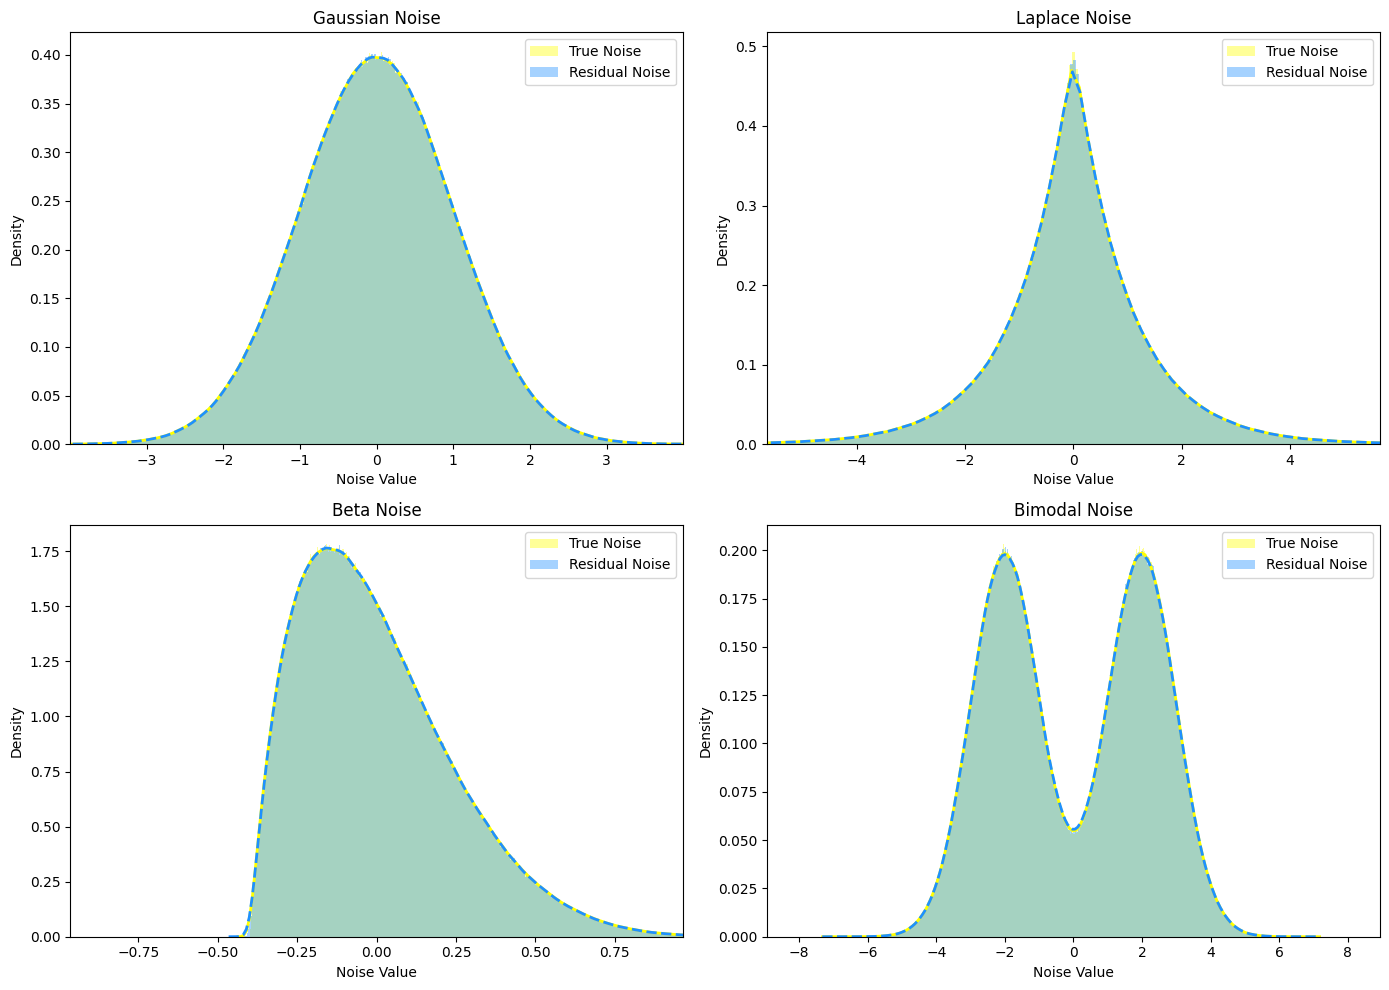

In [10]:
%matplotlib inline
test_denoising(test_movie)
# test_denoising(gaussian_bump)
# test_denoising(travelling_wave)
# test_denoising(whole_brain_wave_1)
# test_denoising(whole_brain_wave_50)

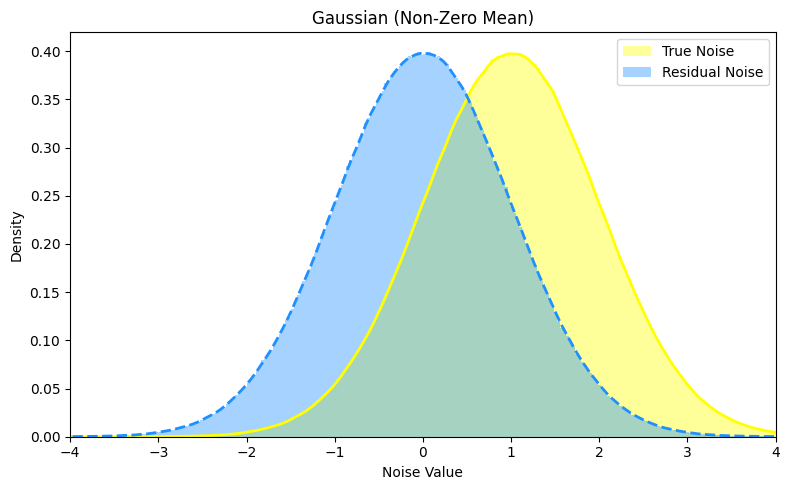

In [45]:
compare_noise_distributions(signal= test_movie, distribution= "Gaussian", noise_params= {'mean':1},
                                bins=300, title="Gaussian (Non-Zero Mean)")

In [11]:
### Gaussian noise
gaussian_noise = np.random.normal(0, 0.5, size=burst.shape)

### Temporally correlated noise (low-pass filtered)
correlated_noise = np.random.normal(0, 1, size=burst.shape)
correlated_noise = gaussian_filter1d(correlated_noise, sigma=3, axis=0)

### Spatially structured noise (slow spatial variation)
noise = np.random.normal(0, 0.5, size=burst.shape)
for i in range(T):
    noise[i] = gaussian_filter1d(noise[i], sigma=5)

### Flicker noise (abrupt jumps)
flicker_noise = np.zeros_like(burst)
for i in range(T):
    if np.random.rand() < 0.1:
        flicker_noise[i] = np.random.normal(0, 0.8, size=(H, W))

### Slow baseline drift
drift = np.linspace(0, 1, T)[:, None, None]
drift_noise = 10 * drift * np.ones_like(X)[None, :, :]

In [12]:
movie_noisy = gaussian_bump + gaussian_noise
movie_denoised = run_less_denoising(movie_noisy, verbose=False)

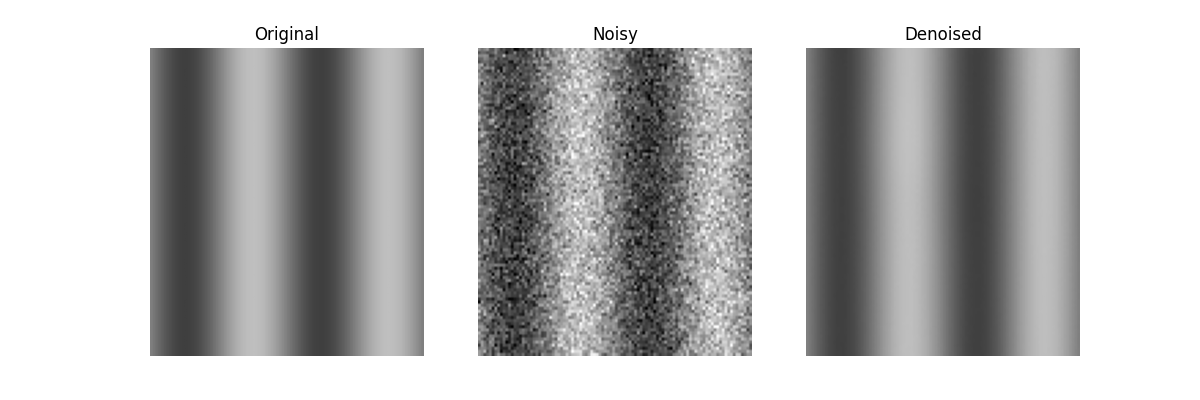

In [13]:
%matplotlib widget
test_movie = gaussian_bump + travelling_wave + burst

ani = denoise_and_plot(test_movie, gaussian_noise, fps)


In [14]:
plt.close('all')